<a href="https://colab.research.google.com/github/LukaT11/quantitative_finance/blob/master/Spearman_Rank_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Measuring monotonic relationships**

The Spearman Rank Correlation Coefficient allows us to determine whether or not two data series move together; that is, when one increases (decreases) the other also increases (decreases). This is more general than a linear relationship; for instance, $y = e^x$ is a monotonic function, but not a linear one. Therefore, in computing it we compare not the raw data but the ranks of the data.

This is useful when your data sets may be in different units, and therefore not linearly related (for example, the price of a square plot of land and its side length, since the price is more likely to be linear in the area). It's also suitable for data sets which not satisfy the assumptions that other tests require, such as the observations being normally distributed as would be necessary for a t-test.

In [0]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

In [0]:
# Example of ranking data
l = [10, 9, 5, 7, 5]

print(f'Raw data: {l}')
print('Ranking: ', stats.rankdata(l, method='average'))

Raw data: [10, 9, 5, 7, 5]
Ranking:  [5.  4.  1.5 3.  1.5]


## **Spearman Rank Correlation**

### **Intuition**

The intution is now that instead of looking at the relationship between the two variables, we look at the relationship between the ranks. This is robust to outliers and the scale of the data.

### **Definition**

The argument `method='average'` indicates that when we have a tie, we average the ranks that the numbers would occupy. For example, the two 5's above, which would take up ranks 1 and 2, each get assigned a rank of $1.5$.

To compute the Spearman rank correlation for two data sets $X$ and $Y$, each of size $n$, we use the formula
$$r_S = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}$$

where $d_i$ is the difference between the ranks of the $i$th pair of observations, $X_i - Y_i$.

The result will always be between $-1$ and $1$. A positive value indicates a positive relationship between the variables, while a negative value indicates an inverse relationship. A value of 0 implies the absense of any monotonic relationship. This does not mean that there is no relationship; for instance, if $Y$ is equal to $X$ with a delay of 2, they are related simply and precisely, but their $r_S$ can be close to zero:

## **Experiment**

Let's see what happens if we draw $X$ from a poisson distribution (non-normal), and then set $Y = e^X + \epsilon$ where $\epsilon$ is drawn from another poisson distribution. We'll take the spearman rank and the correlation coefficient on this data and then run the entire experiment many times. Because $e^X$ produces many values that are far away from the rest, we can this of this as modeling 'outliers' in our data. Spearman rank compresses the outliers and does better at measuring correlation. Normal correlation is confused by the outliers and on average will measure less of a relationship than is actually there.

In [0]:
## Let's see an example of this
n = 100

def compare_correlation_and_spearman_rank(n, noise):
  X = np.random.poisson(size = n)
  Y = np.exp(X) + noise * np.random.normal(size = n)
  
  Xrank = stats.rankdata(X, method = 'average')
  Yrank = stats.rankdata(Y, method = 'average')
  
  diff = Xrank - Yrank                                 # order doesn't matter since we'll be squaring these values
  r_s = 1 - 6*sum(diff**2)/(n*(n**2-1))
  c_c = np.corrcoef(X, Y)[0, 1]
  
  return r_s, c_c

experiments = 100
spearman_dist = np.ndarray(experiments)
correlation_dist = np.ndarray(experiments)

for i in range(experiments):
  r_s, c_c = compare_correlation_and_spearman_rank(n, 1.0)
  spearman_dist[i] = r_s
  correlation_dist[i] = c_c
  
print(f'Spearman Rank Coefficient: {np.mean(spearman_dist)}')
print(f'Correlation Coefficient: {np.mean(correlation_dist)}')

Spearman Rank Coefficient: 0.8758121212121214
Correlation Coefficient: 0.7704047234104341


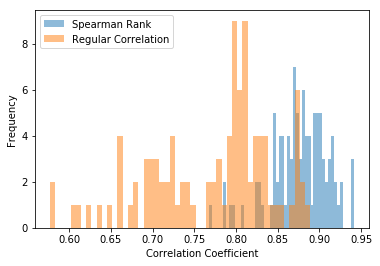

In [0]:
plt.hist(spearman_dist, bins=50, alpha=0.5)
plt.hist(correlation_dist, bins=50, alpha=0.5)
plt.legend(['Spearman Rank', 'Regular Correlation'])
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency');

Now let's see how the Spearman rank and Regular coefficients cope when we add more noise to the situation.

Text(0, 0.5, 'Average Correlation Coefficient')

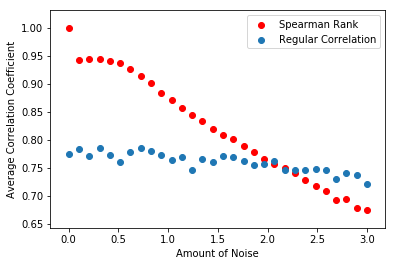

In [0]:
n = 100
noises = np.linspace(0, 3, 30)
experiments = 100
spearman = np.ndarray(len(noises))
correlation = np.ndarray(len(noises))

for i in range(len(noises)):
  # Run many experiments for each noise setting
  ran_coef = 0.0
  corr_coef = 0.0
  noise = noises[i]
  
  for j in range(experiments):
    r_s, c_c = compare_correlation_and_spearman_rank(n, noise)
    ran_coef += r_s
    corr_coef += c_c
    
  spearman[i] = ran_coef/experiments
  correlation[i] = corr_coef/experiments
    
plt.scatter(noises, spearman, color='r')
plt.scatter(noises, correlation)
plt.legend(['Spearman Rank', 'Regular Correlation'])
plt.xlabel('Amount of Noise')
plt.ylabel('Average Correlation Coefficient')  

We can see that the Spearman rank correlation copes with the non-linear relationship much better at most levels of noise. Interestingly, at very high levels, it seems to do worse than regular correlation.

In [0]:
n = 100

X = np.random.rand(n)
Xrank = stats.rankdata(X, method='average')
# n-2 is the second to last element
Yrank = stats.rankdata([1,1] + list(X[:(n-2)]), method='average')

diff = Xrank - Yrank

r_s = 1 - 6 * sum(diff**2)/(n*(n**2-1))
r_s

-0.05912691269126902

Sure enough, the relationship is not detected. It is important when using both regular and spearman correlation to check for lagged relationships by offsetting your data and testing for different offset values.

## **Built-In Function**

We can also use the `spearmanr` function in the `scipy.stats` library:

In [0]:
# Generate two random data sets
np.random.seed(161)
X = np.random.rand(10)
Y = np.random.rand(10)

r_s = stats.spearmanr(X, Y)

print(f'Correlation: {r_s[0]}')
print(f'P value: {r_s[1]}')

Correlation: 0.23636363636363633
P value: 0.5108853175152002
